In [1]:
import time
import pandas as pd
from utils.hdr_utils import hdr_yuv_read
from utils.csf_utils import blockwise_csf,windows_csf
from joblib import Parallel,delayed
import numpy as np
import cv2
import queue
import glob
from colour.models import eotf_PQ_BT2100
import os
import time
import scipy.ndimage
import joblib
from scipy.stats import gmean
import sys
import matplotlib.pyplot as plt
import ChipQA.niqe 
import ChipQA.save_stats
from numba import jit,prange,njit
import argparse
from scipy.stats import kurtosis
from skimage.util.shape import view_as_blocks

In [2]:

C=1
def gen_gauss_window(lw, sigma):
    sd = np.float32(sigma)
    lw = int(lw)
    weights = [0.0] * (2 * lw + 1)
    weights[lw] = 1.0
    sum = 1.0
    sd *= sd
    for ii in range(1, lw + 1):
        tmp = np.exp(-0.5 * np.float32(ii * ii) / sd)
        weights[lw + ii] = tmp
        weights[lw - ii] = tmp
        sum += 2.0 * tmp
    for ii in range(2 * lw + 1):
        weights[ii] /= sum
    return weights
def compute_image_mscn_transform(image, C=1, avg_window=None, extend_mode='reflect'):
    if avg_window is None:
      avg_window = gen_gauss_window(3, 7.0/6.0)
    assert len(np.shape(image)) == 2
    h, w = np.shape(image)
    mu_image = np.zeros((h, w), dtype=np.float32)
    var_image = np.zeros((h, w), dtype=np.float32)
    image = np.array(image).astype('float32')
    scipy.ndimage.correlate1d(image, avg_window, 0, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(mu_image, avg_window, 1, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(image**2, avg_window, 0, var_image, mode=extend_mode)
    scipy.ndimage.correlate1d(var_image, avg_window, 1, var_image, mode=extend_mode)
    var_image = np.sqrt(np.abs(var_image - mu_image**2))
    mscn = (image - mu_image)/(var_image + C)
    return mscn, image - mu_image, var_image

def spatiotemporal_mscn(img_buffer,avg_window,extend_mode='mirror'):
    st_mean = np.zeros((img_buffer.shape))
    scipy.ndimage.correlate1d(img_buffer, avg_window, 0, st_mean, mode=extend_mode)
    return st_mean

def block_compute_lnl(block,delta,lnl_transform='exp_inv'):
    block = block.astype(np.float32)
    avg_luminance = np.average(block.flatten()+1)
    if(lnl_transform=='sigmoid'):
        block_transform =  1/(1+np.exp(-delta*(block-avg_luminance)))
    elif(lnl_transform=='nakarushton'):
        block_transform = block/(block+avg_luminance)
    elif(lnl_transform=='exp'):
        block = -4+(block-np.amin(block))* 8/(1e-3+np.amax(block)-np.amin(block))
        block_transform =  np.exp(np.abs(block)**delta)-1
        block_transform[block<0] = -block_transform[block<0]
    elif(lnl_transform=='logit'):
        block = -0.99+(block-np.amin(block))* 1.98/(1e-3+np.amax(block)-np.amin(block))
        block_transform = np.log((1+(block)**delta)/(1-(block)**delta))
        if(delta%2==0):
            block_transform[block<0] = -block_transform[block<0] 
            
    return block_transform

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

@njit(parallel=True)
def AdaptiveLogit(img,s,delta):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = s//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in prange(a,H+a+1):
        for j in range(a,W+a+1):
            value = logit_window(padded_img,i,j,s,delta)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 

@njit
def logit(x,delta):
    if(delta%2==1):
        return np.log((1+(x)**delta)/(1-(x)**delta))
    else:
        if(x<0):
            return -np.log((1+(x)**delta)/(1-(x)**delta))
        else:
            return np.log((1+(x)**delta)/(1-(x)**delta))
@njit
def logit_window(Y,x,y,s,delta):
    block = Y[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    center_pixel_scaled = -0.99+(block[s//2,s//2]-np.amin(block))* 1.98/(1e-3+np.amax(block)-np.amin(block))
    result = logit(center_pixel_scaled,delta)
            

            
    return result
            
def spatial_mscn(i,filenames,framenum,hs,ws,use_csf=True,linear=True):
    filename = filenames[i] # '/home/josh-admin/Downloads/288p_200kbps_CenterPanorama_upscaled.yuv' #
    name = os.path.basename(filename)
    print(name) 
    framenos = framenos_list[i]



    # SIZE of frames
    h,w = hs[i],ws[i]
    print(h,w)
    if(h>w):
        h_temp = h
        h=w
        w = h_temp
        
    # SIZE of windows
    h_win,w_win = 45,45
    max_h,max_w = int((h//h_win)*h_win),int((w//w_win)*w_win)
    #percent by which the image is resized
    scale_percent = 0.5
    # dsize
    dsize = (int(scale_percent*h),int(scale_percent*w))

    # opening file object
    dis_file_object = open(filename)
    prevY_pq,_,_ = hdr_yuv_read(dis_file_object,framenum,h,w)
    count=1
    prevY_pq = prevY_pq.astype(np.float32)
    if(linear==True):
        y_pq_normalized = prevY_pq.astype(np.float32)/1024.0
        prevY_pq = eotf_PQ_BT2100(y_pq_normalized)

#     blocks = blockshaped(prevY_pq[:max_h,:max_w],h_win,w_win)
#     Y = unblockshaped(blocks,max_h,max_w)
    Y_mscn,Y_ms = compute_image_mscn_transform(Y)
    lnl_mscn_list =[]
    lnl_list = []
    lnl_ms_list = []
    
    for delta in [1,2,3]:
#         block_lnl = Parallel(n_jobs=20,verbose=0)(delayed(block_compute_lnl)(block,delta,lnl_transform='logit')\
#                                                               for block in blocks) 
#         Y_lnl = unblockshaped(np.asarray(block_lnl),max_h,max_w)
        Y_lnl= block_compute_lnl(Y,delta,lnl_transform='logit')
#         start = time.time()
#         Y_lnl = AdaptiveLogit(Y,s=45,delta=delta)
#         end = time.time()
#         print(end-start)
        Y_lnl_mscn,Y_lnl_ms = compute_image_mscn_transform(Y_lnl,C=1e-3)
        
        lnl_list.append(Y_lnl)
        lnl_mscn_list.append(Y_lnl_mscn)
        lnl_ms_list.append(Y_lnl_ms)
    return Y, Y_mscn,lnl_list,lnl_mscn_list,lnl_ms_list







(2, 0.11214350576230298, 0.48902855813800483)


<IPython.core.display.Javascript object>


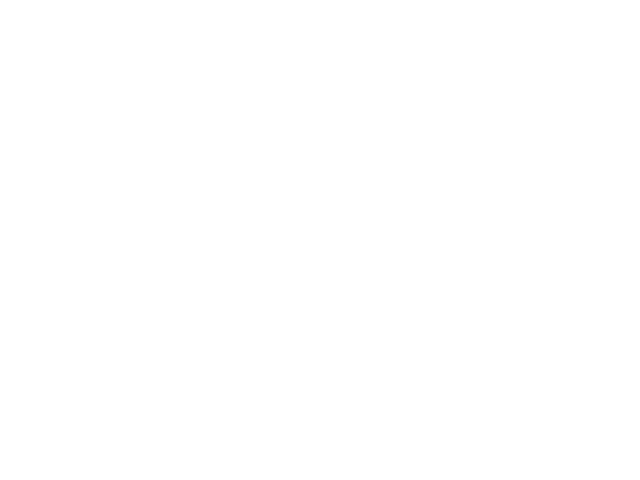

2501
0.0187743
(3, 0.093408882042837788, 0.53096553683557324)


<IPython.core.display.Javascript object>


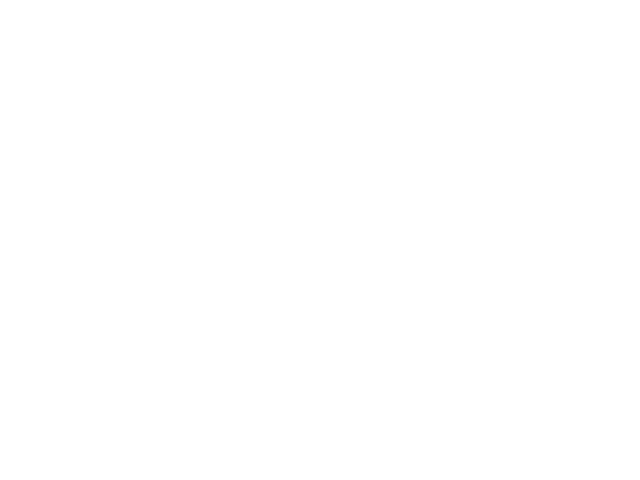

2501
0.0187743
(4, 0.079587994013916252, 0.55664566159419904)


<IPython.core.display.Javascript object>


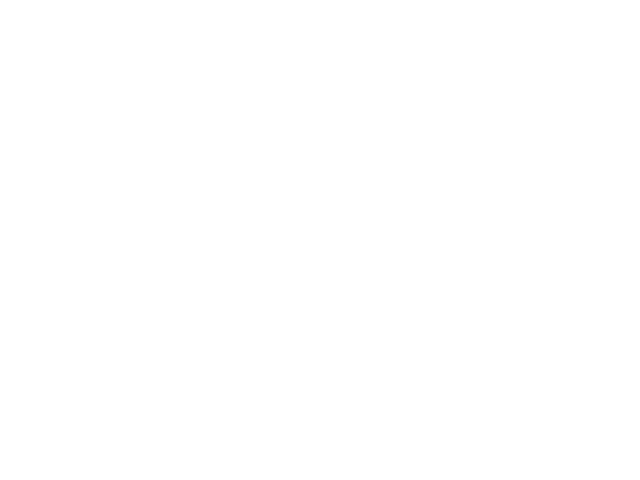

2501
0.0187743
(5, 0.071502114366574498, 0.57401815056873029)


<IPython.core.display.Javascript object>


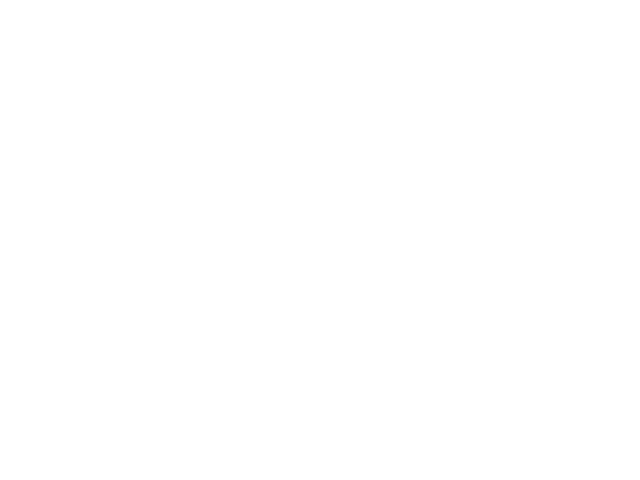

2501
0.0187743
(10, 0.048732568793433906, 0.61454716324861858)


<IPython.core.display.Javascript object>


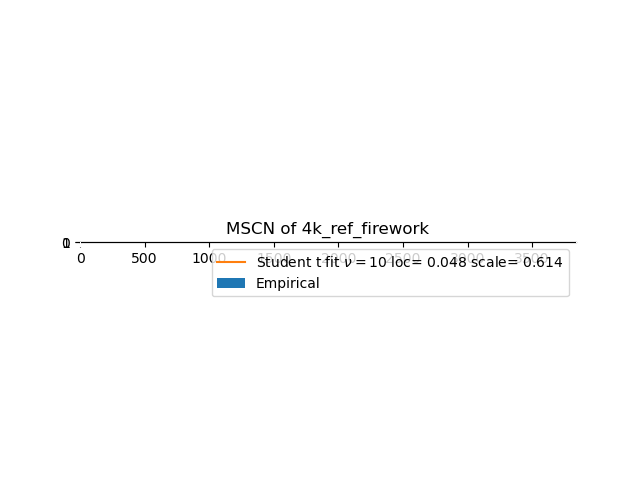

2501
0.0187743


In [13]:
input_folder = '/media/josh/nebula_josh/hdr/fall2021_hdr_yuv'
csv_file = './fall2021_yuv_rw_info.csv'
csv_df = pd.read_csv(csv_file)
files = [os.path.join(input_folder,f) for f in csv_df["yuv"]]
fps = csv_df["fps"]
framenos_list = csv_df["framenos"]
ws =csv_df["w"]
hs = csv_df["h"]
flag = 0


%matplotlib notebook
%matplotlib notebook

delta =[1,2,3]
from scipy.stats import t

ms_means = []
mscn_means = []
std_means = []
for i,f in enumerate(files):
    if('ref_firework' in f):
        base = os.path.splitext(os.path.basename(f))[0]
        dis_file_object = open(f)
        Y,_,_ = hdr_yuv_read(dis_file_object,10,2160,3840)
#         Y = -Y
        Y_mscn,Y_ms,local_std = compute_image_mscn_transform(Y)

#         Y,Y_mscn,Y_lnl_list,Y_lnl_mscn_list,lnl_ms_list = spatial_mscn(i,files,10,hs,ws,linear=False)
        Yplot = np.concatenate(Y_mscn).flatten()
        alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
        kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
        x = np.arange(-1.5,1.5,0.001)
        Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
        for dof in [2,3,4,5,10]:
            student_t = t.fit(Yplot.flatten(),f0=dof)
            print(student_t)
            student_t_fitted = t.pdf(x, loc=student_t[1], scale=student_t[2], df=student_t[0])
            plt.figure()
            plt.clf()
            n,bins,_ = plt.hist(Y_mscn.flatten(),range=[-1.5,1.5],bins=2500,label=r'Empirical',density=True)
            print(len(bins))
            print(np.mean(Yplot))
#             plt.plot(x,Y_ggd,label=r'GGD fit $\alpha=$'+str(alpha)[:4])
            plt.plot(x,student_t_fitted,label=r'Student t fit $\nu=$'+str(student_t[0])[:5]+' loc= '+str(student_t[1])[:5]+' scale= '+str(student_t[2])[:5])
            ax = plt.gca()
            ax.set_ylim([0,1.4])
            plt.title('MSCN of '+base)
            plt.legend()
#         plt.imshow(Y,cmap='gray')

            plt.savefig('./images/ref_mscn_fixed_dof'+str(student_t[0])[:5]+'/'+base+'_hist.png')


#    Parallel(n_jobs=5)(delayed(sts_fromfilename)(i,files,framenos_list,args.results_folder,use_csf=False) for i in range(len(files)))
# Y,Y_mscn,Y_lnl_list,Y_lnl_mscn_list,lnl_ms_list = spatial_mscn(187,files,10,hs,ws,linear=False)







In [14]:
plt.figure()
plt.imshow(-Y,cmap='gray')

# Reference MSCNs

/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


<IPython.core.display.Javascript object>


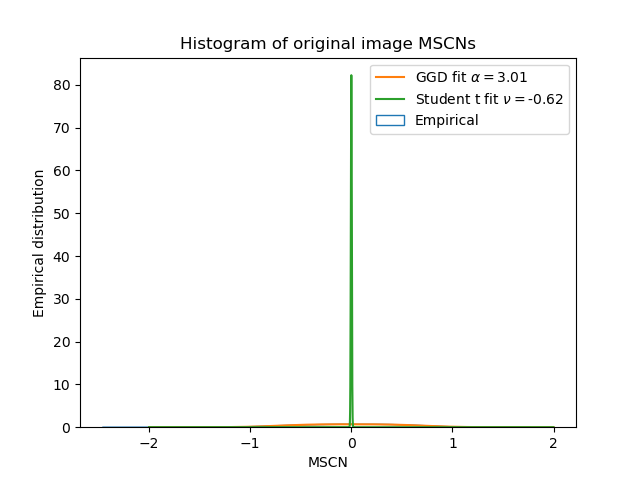

In [11]:


%matplotlib notebook
%matplotlib notebook

delta =[1,2,3]
from scipy.stats import t
# for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
#     if(index==0):
#         continue
#     print(np.amax(Y_lnl_mscn))
#     Yplot = np.concatenate(Y_lnl_mscn).flatten()
#     sigma = np.var(Yplot.flatten())
#     nu = 2*sigma/(sigma-1)
#     print(nu)
#     student_t = t.fit(Yplot.flatten(),floc=0)
#     print(student_t)
#     alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot)
#     kurt = kurtosis(Yplot,fisher=False)
#     x = np.arange(-2,2,0.001)
#     student_t_fitted = t.pdf(x, loc=student_t[1], scale=student_t[2], df=student_t[0])

#     Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
#     Y_lnl = Y_lnl_list[index]
    

# # plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
# #plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# # plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


#     plt.figure()
#     plt.clf()
#     plt.hist(Yplot,bins='auto',histtype='step',label=r'Empirical',density=True)

# #     plt.hist(Yplot,bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
#     plt.plot(x,Y_ggd, label=r'GGD fit $\alpha=$'+str(alpha)[:4])
#     plt.plot(x,student_t_fitted,label=r'Student t fit $\nu=$'+str(nu)[:5])
#     plt.ylabel('Empirical distribution')
#     plt.xlabel('MSCN')
#     plt.title('Histogram of nonlinear MSCN')
#     plt.legend()
#     plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
student_t = t.fit(Yplot.flatten(),floc=0)
student_t_fitted = t.pdf(x, loc=student_t[1], scale=student_t[2], df=student_t[0])
plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'Empirical',density=True)
plt.plot(x,Y_ggd,label=r'GGD fit $\alpha=$'+str(alpha)[:4])
plt.plot(x,student_t_fitted,label=r'Student t fit $\nu=$'+str(nu)[:5])

plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
# plt.figure()
# plt.clf()
# Yplot = Y.flatten()
# plt.hist(Yplot,bins='auto',histtype='step',label=r'original image',density=True)
# plt.legend()

In [ ]:


%matplotlib notebook
%matplotlib notebook

delta =[1,1.5,2]

for index,Y_lnl_ms in enumerate(lnl_ms_list):
    Yplot = np.concatenate(Y_lnl_ms).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-1,1,0.0001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MS')
    plt.legend()
    plt.show()
    


<IPython.core.display.Javascript object>


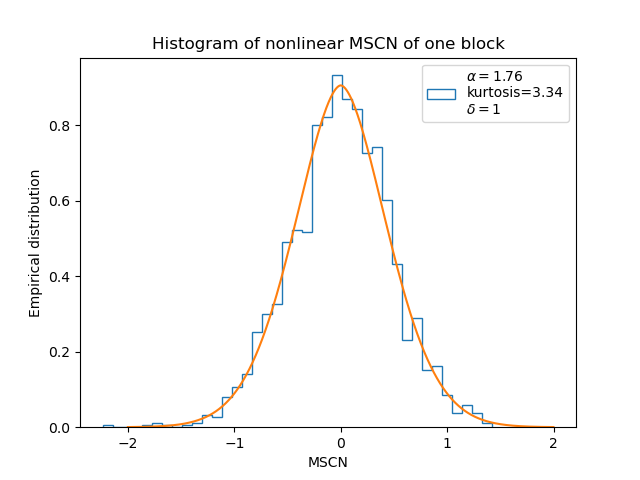

<IPython.core.display.Javascript object>


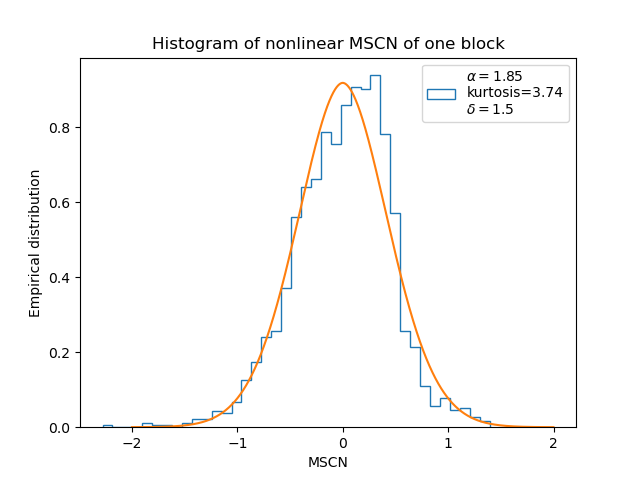

<IPython.core.display.Javascript object>


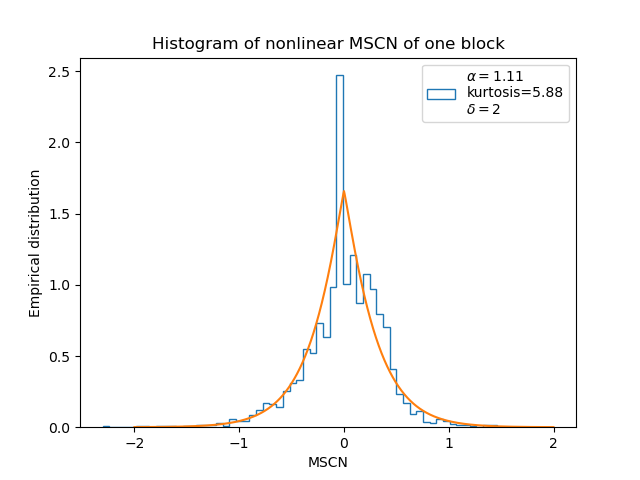

<IPython.core.display.Javascript object>


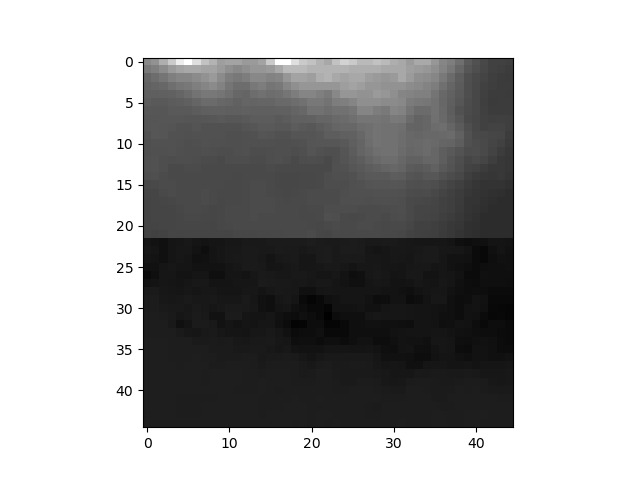

In [10]:
max_h,max_w = Y_lnl.shape[0],Y_lnl.shape[1]
h_win,w_win = 45,45
for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    Y_lnl = Y_lnl_list[index]

    blocks = blockshaped(Y_lnl[:max_h,:max_w],h_win,w_win)
    
    block_mscn,_ = compute_image_mscn_transform(blocks[87],C=1e-3)

    Yplot = np.concatenate(block_mscn).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-2,2,0.001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MSCN of one block')
    plt.legend()
    plt.show()
    
plt.figure()
plt.imshow(blocks[45],cmap='gray')

# Reference second order stats

(20,)


<IPython.core.display.Javascript object>


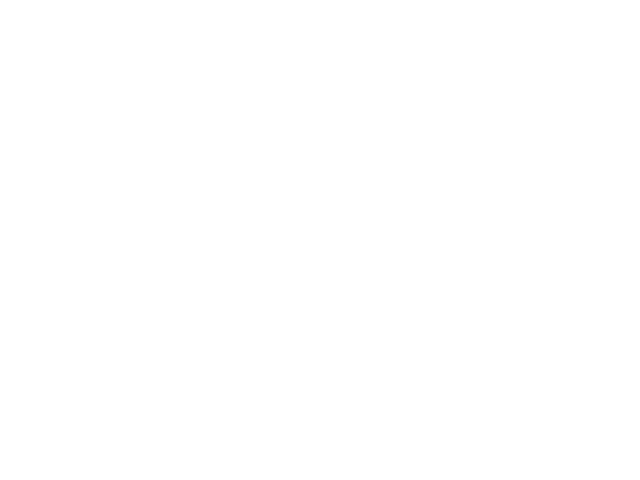

(20,)


/tmp/ipykernel_111923/3244713517.py:8: RuntimeWarning: invalid value encountered in sqrt
  sigma_l  = np.sqrt(aggd_feats[1])


<IPython.core.display.Javascript object>


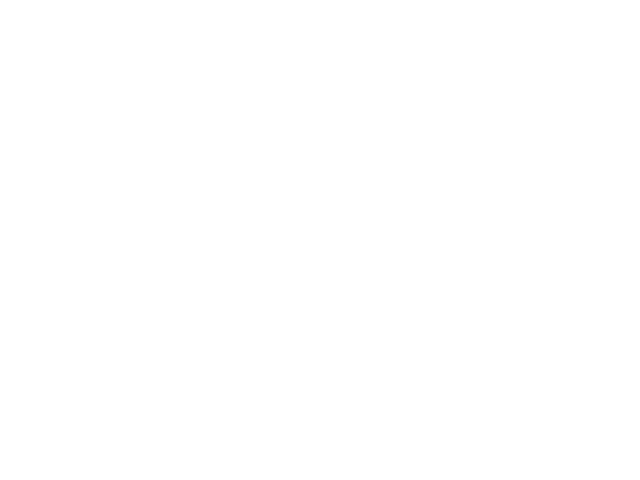

(20,)


/tmp/ipykernel_111923/3244713517.py:8: RuntimeWarning: invalid value encountered in sqrt
  sigma_l  = np.sqrt(aggd_feats[1])


<IPython.core.display.Javascript object>


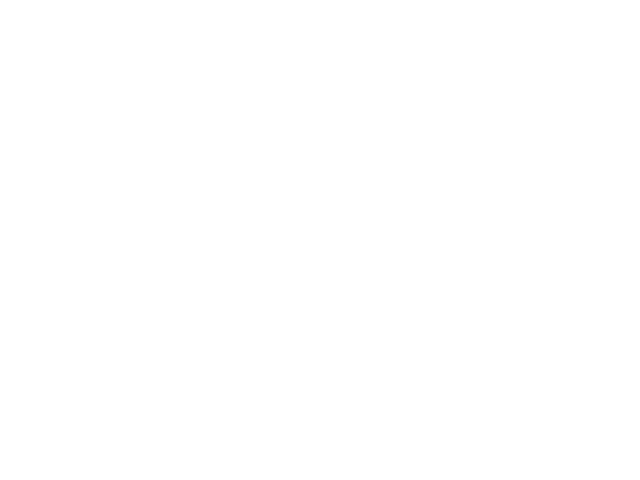

<IPython.core.display.Javascript object>


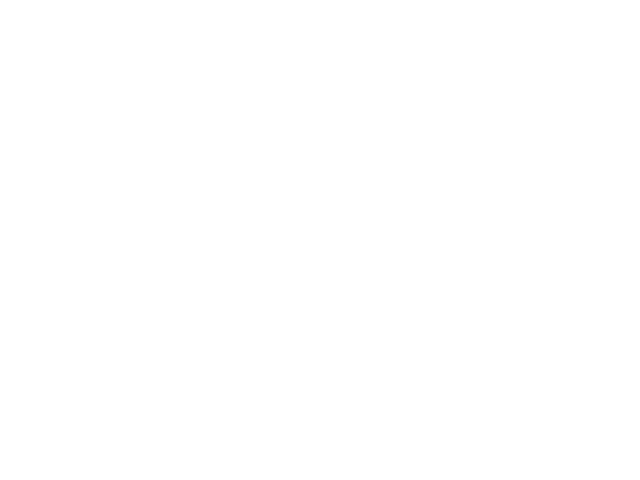

<IPython.core.display.Javascript object>


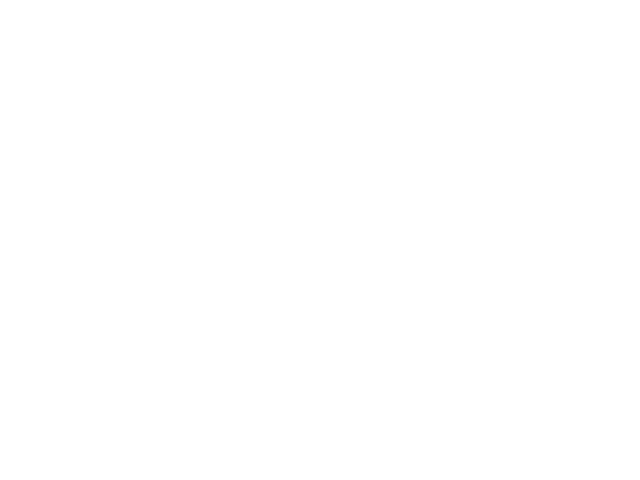

In [99]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

def get_aggd(aggd_feats):
    alpha = aggd_feats[0]
    sigma_l  = np.sqrt(aggd_feats[1])
    sigma_r  = np.sqrt(aggd_feats[2])
    x1 = np.arange(-2,0,0.001)
    x2 = np.arange(0,2,0.001)
    Y_aggd = ChipQA.save_stats.generate_aggd(x1,x2,alpha,sigma_l,sigma_r)
    return Y_aggd

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    pps1, pps2, pps3, pps4 = ChipQA.save_stats.paired_product(Y_lnl_mscn)
    aggd_features = ChipQA.save_stats.all_aggd(Y_lnl_mscn)
    print(aggd_features.shape)
    first_order = aggd_features[0:4]
    H_feats = aggd_features[4:8]
    V_feats = aggd_features[8:12]
    D1_feats = aggd_features[12:16]
    D2_feats = aggd_features[16:20]

    H_aggd = get_aggd(H_feats)
    V_aggd = get_aggd(V_feats)
    D1_aggd = get_aggd(D1_feats)
    D2_aggd = get_aggd(D2_feats)

    Y_lnl = Y_lnl_list[index]
    x = np.arange(-2,2,0.001)
    
    Yplot = pps1.flatten()
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(H_feats[0])[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,H_aggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear Horizontal MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'original image',density=True)
plt.legend()

## Reference LNL images

<IPython.core.display.Javascript object>


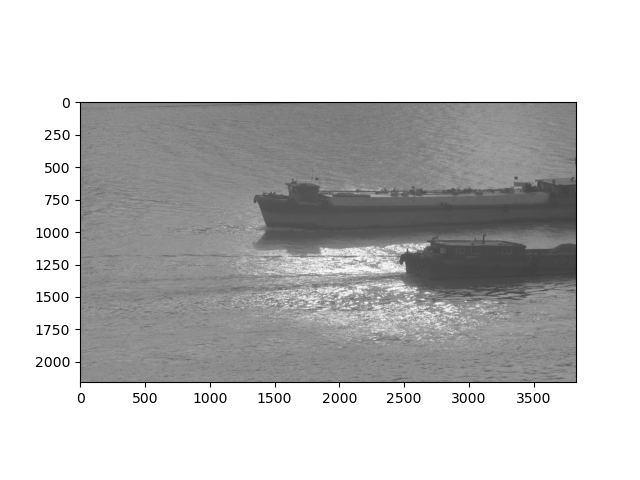

(2160, 3825)


<IPython.core.display.Javascript object>


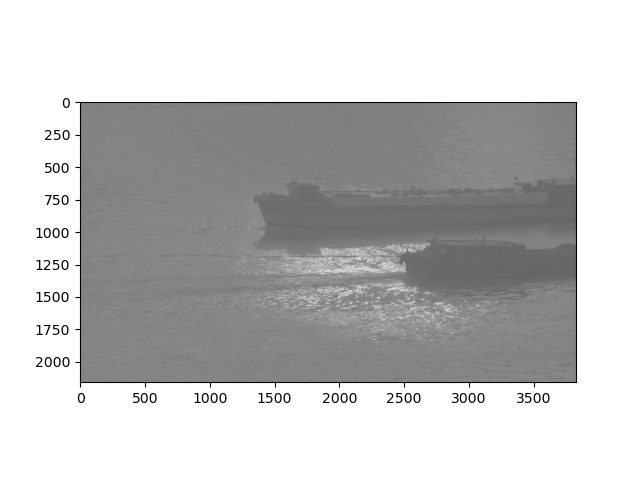

-5.29331
(2160, 3825)
(2160, 3825)


<IPython.core.display.Javascript object>


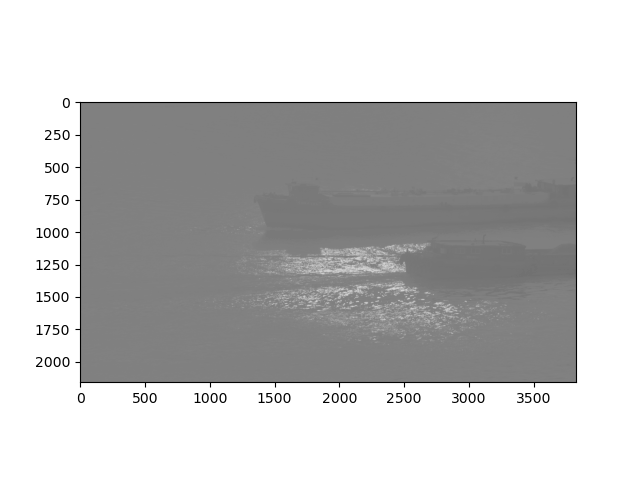

-4.60018
(2160, 3825)
(2160, 3825)


<IPython.core.display.Javascript object>


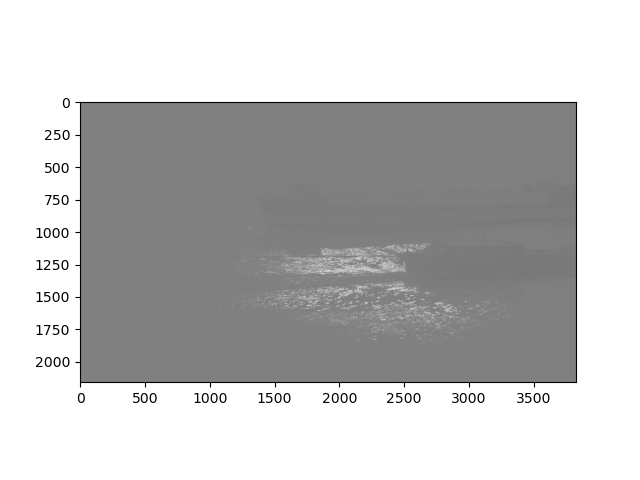

-4.19476
(2160, 3825)
(2160, 3825)


In [10]:
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = -0.99+(Y-np.amin(Y))* 1.98/(np.amax(Y)-np.amin(Y))

h_top = Y_fcfs.shape[0]//2
w_top = Y_fcfs.shape[1]//2
plt.imshow(Y_fcfs,cmap='gray')
print(Y.shape)
for index,Y_lnl in enumerate(Y_lnl_list):
    Y_lnl = Y_lnl.astype(np.float32)
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl-np.amin(Y_lnl))/(np.amax(Y_lnl)-np.amin(Y_lnl))
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2
    print(np.amin(Y_lnl))
    print(Y_fcfs.shape)
    plt.imshow(Y_fcfs,cmap='gray')

    plt.savefig('./images/nonoverlap_check_'+str(index)+'.png')
    print(Y_lnl.shape)

## Reference MSCN

<IPython.core.display.Javascript object>


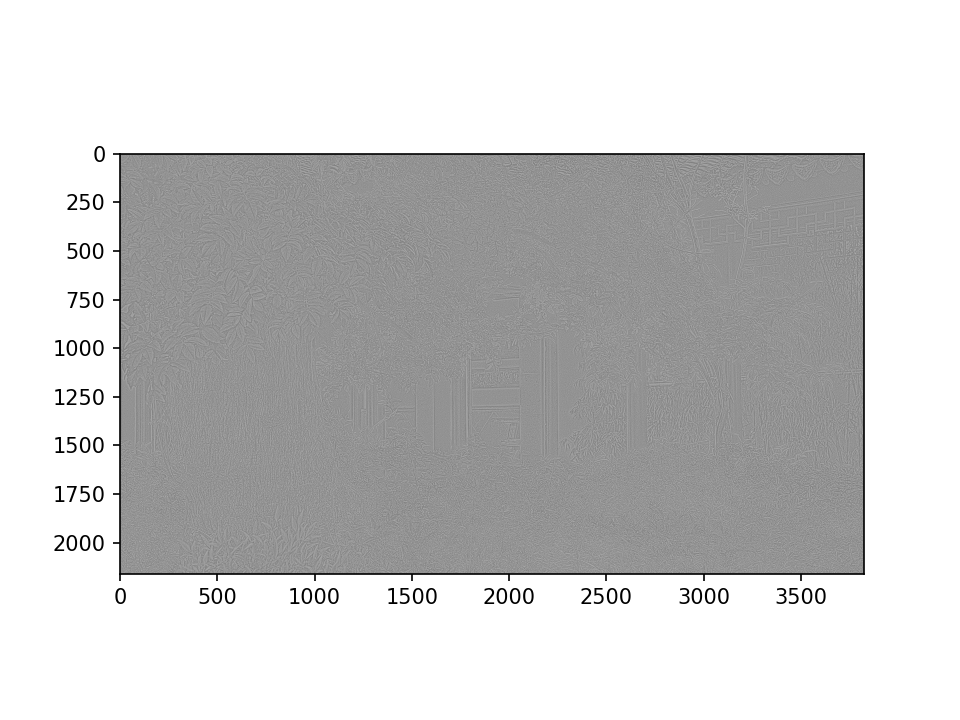

(2160, 3825)


<IPython.core.display.Javascript object>


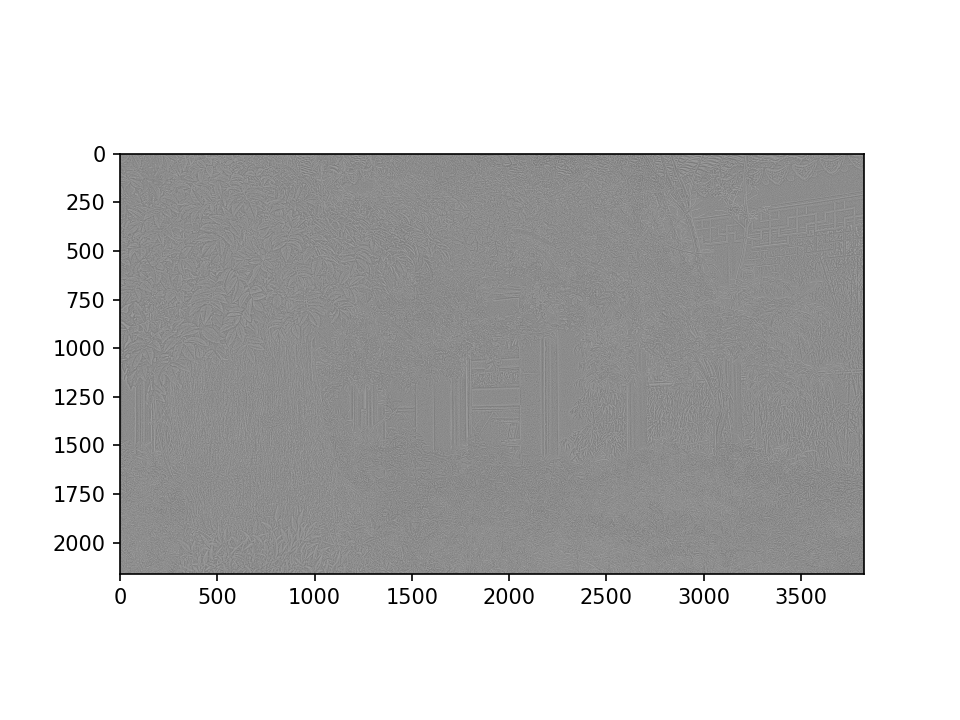

<IPython.core.display.Javascript object>


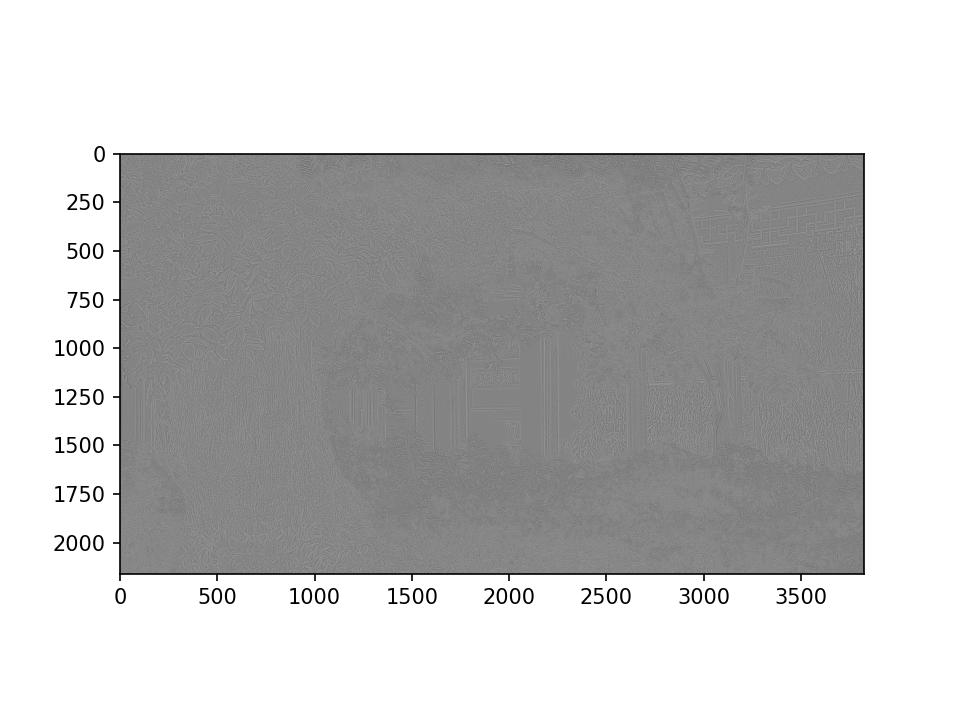

<IPython.core.display.Javascript object>


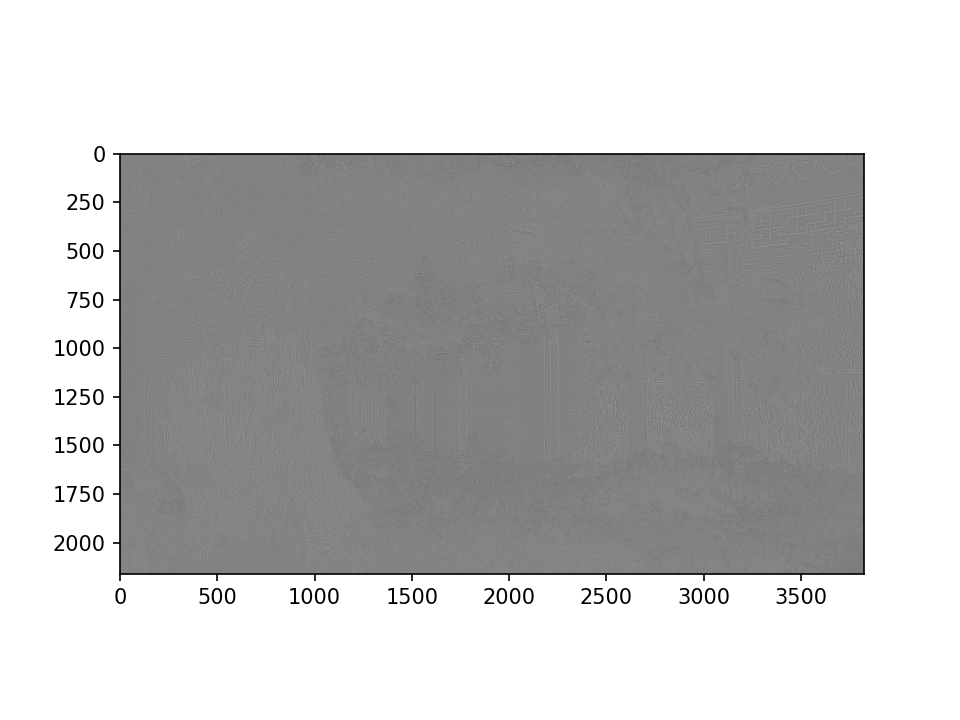

<IPython.core.display.Javascript object>


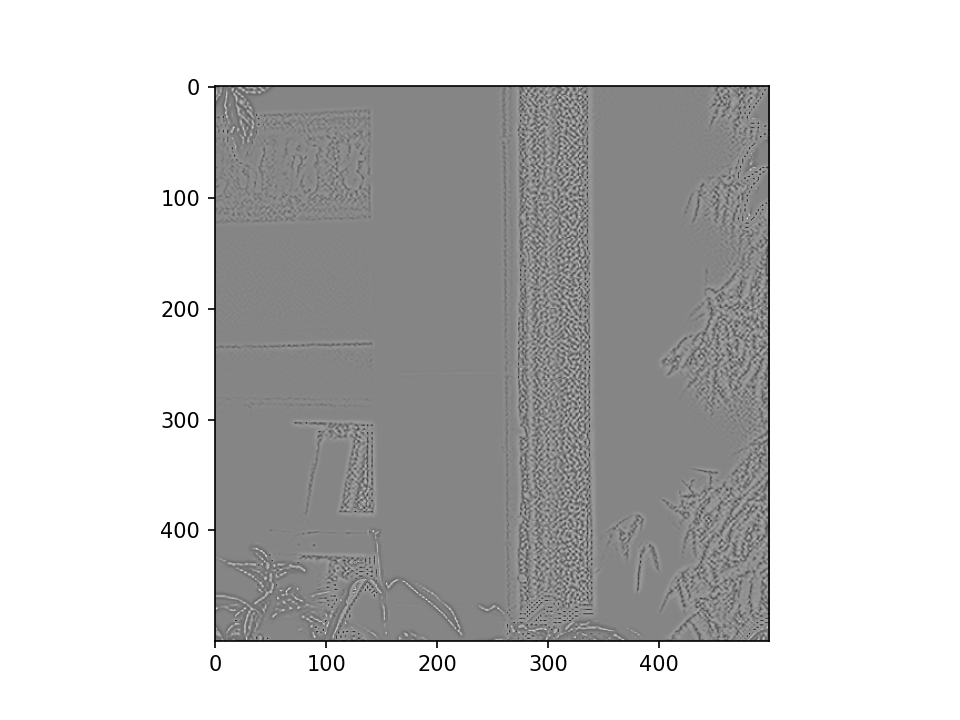

In [55]:
%matplotlib notebook
%matplotlib notebook

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)

%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = (Y_mscn-np.amin(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn,cmap='gray')
print(Y_fcfs.shape)
for Y_lnl_mscn in Y_lnl_mscn_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl_mscn-np.amin(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs,cmap='gray')
plt.figure()
blur = cv2.GaussianBlur(Y_fcfs[h_top:h_top+500,w_top:w_top+500],(5,5),0)
plt.imshow(Y_fcfs[h_top:h_top+500,w_top:w_top+500],cmap='gray')

<IPython.core.display.Javascript object>


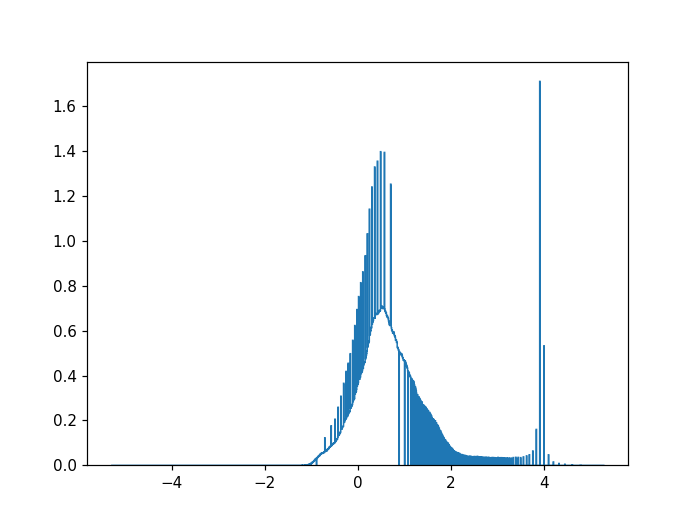

(2160, 3840)


<IPython.core.display.Javascript object>


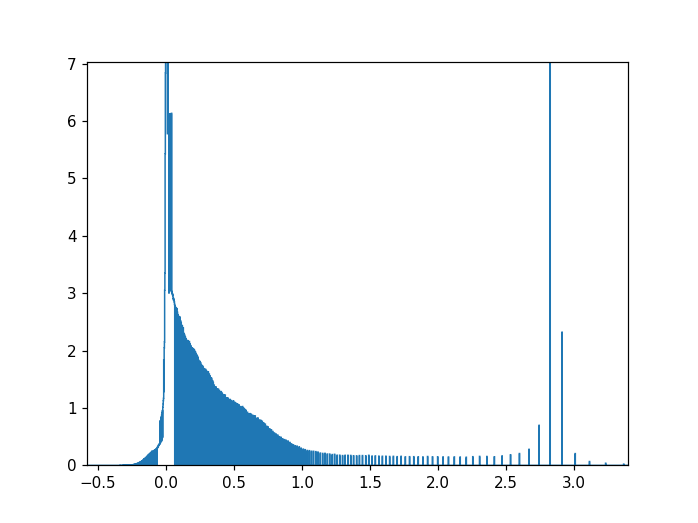

(2160, 3840)


<IPython.core.display.Javascript object>


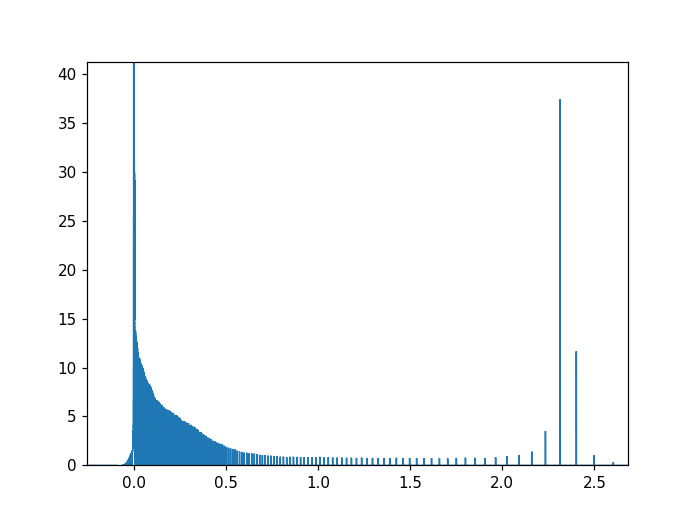

(2160, 3840)


In [35]:
%matplotlib notebook
%matplotlib notebook



for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)

    plt.figure()
    plt.clf()
    Yplot = Y_lnl.flatten()
    plt.hist(Yplot,bins='auto',histtype='step',density=True)
    plt.show()

    print(Y_lnl.shape)


## Distorted MSCN

<IPython.core.display.Javascript object>


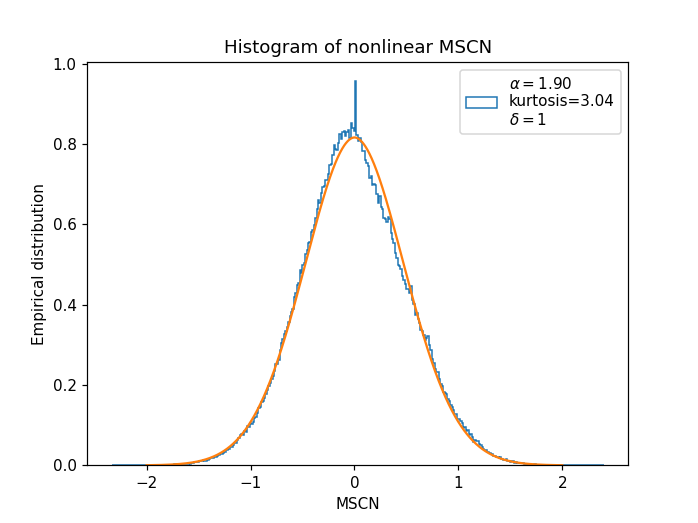

<IPython.core.display.Javascript object>


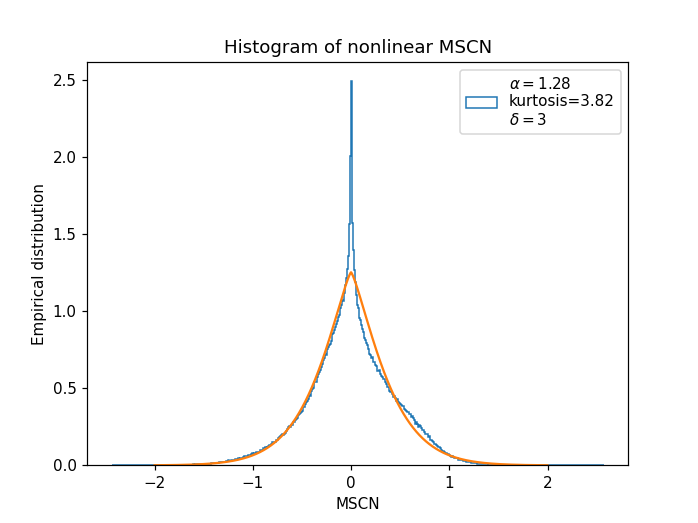

<IPython.core.display.Javascript object>


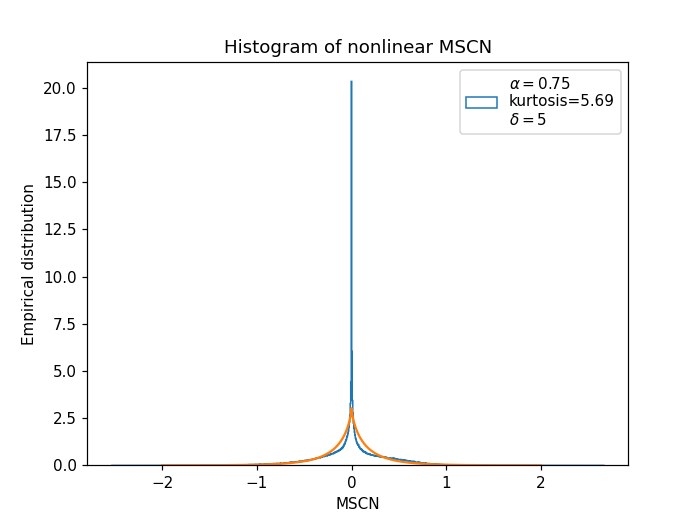

<IPython.core.display.Javascript object>


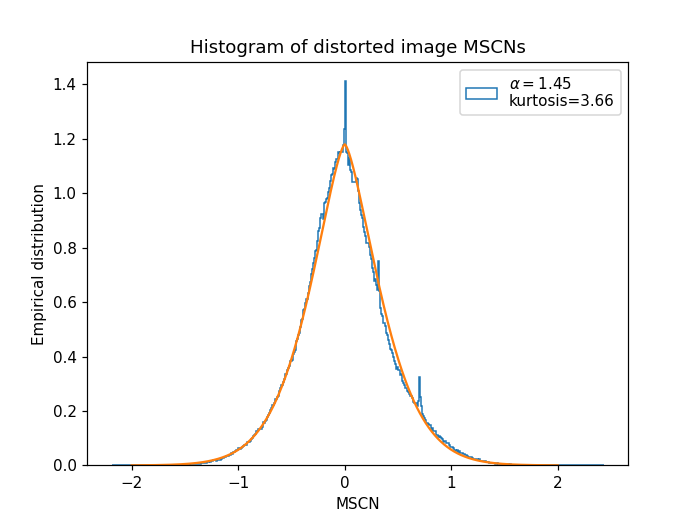

<IPython.core.display.Javascript object>


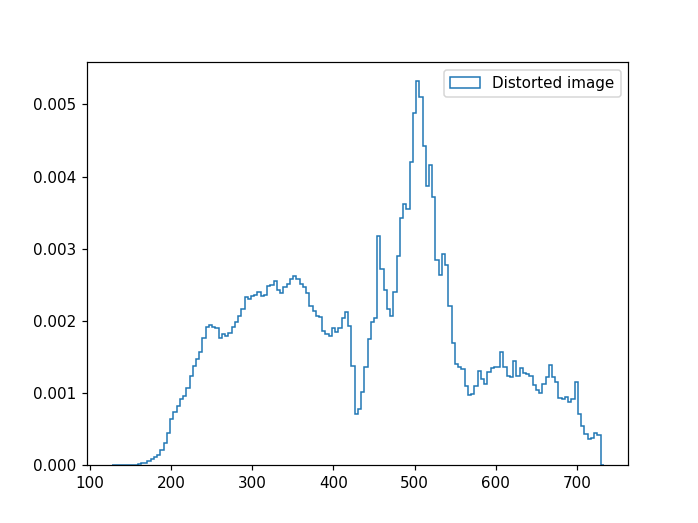

In [236]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    Yplot = np.concatenate(Y_lnl_mscn).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-2,2,0.001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    Y_lnl = Y_lnl_list[index]
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of distorted image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'Distorted image',density=True)
plt.legend()




## Distorted LNL images

<IPython.core.display.Javascript object>


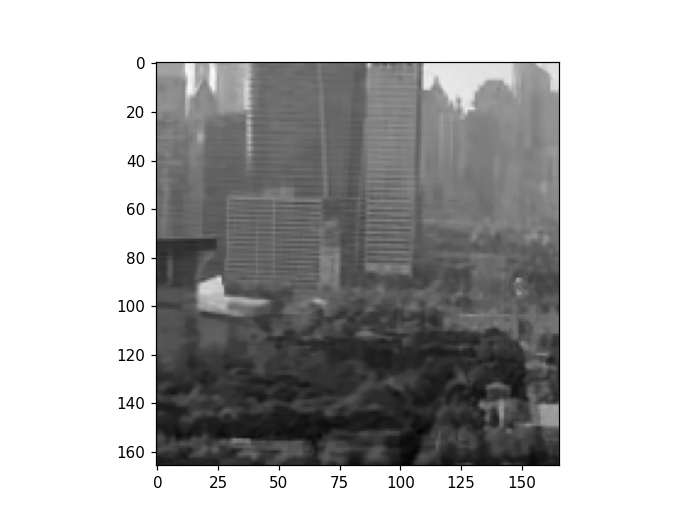

<IPython.core.display.Javascript object>


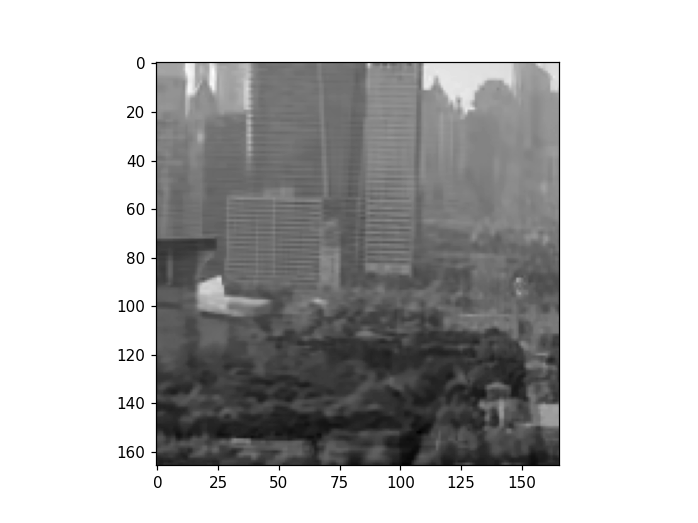

<IPython.core.display.Javascript object>


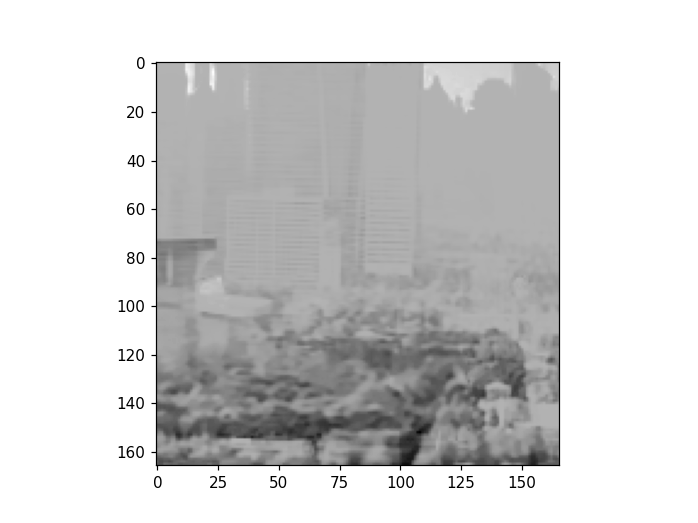

<IPython.core.display.Javascript object>


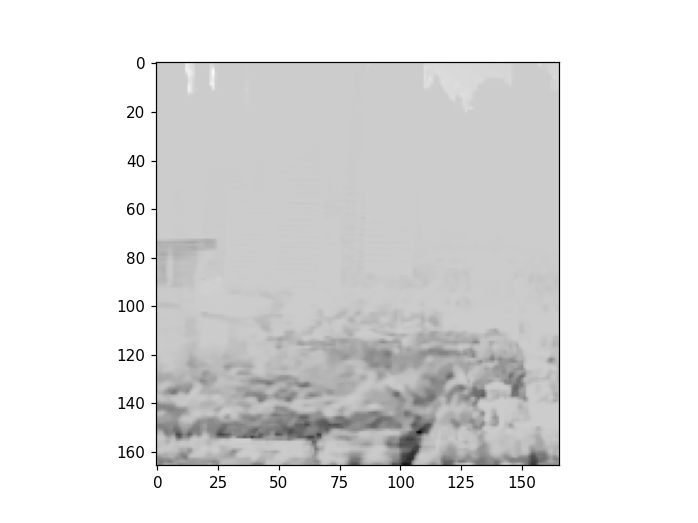

In [234]:
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
plt.imshow(Y[h_top:h_top+166,w_top:w_top+166],cmap='gray')
# plt.imshow(Y,cmap='gray')
for Y_lnl in Y_lnl_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl-np.amin(Y_lnl))/(np.amax(Y_lnl)-np.amin(Y_lnl))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+166,w_top:w_top+166],cmap='gray')

<IPython.core.display.Javascript object>


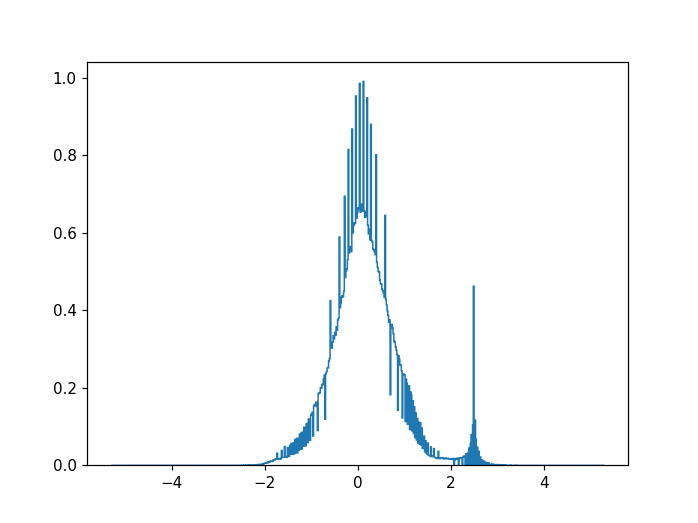

(720, 1280)


<IPython.core.display.Javascript object>


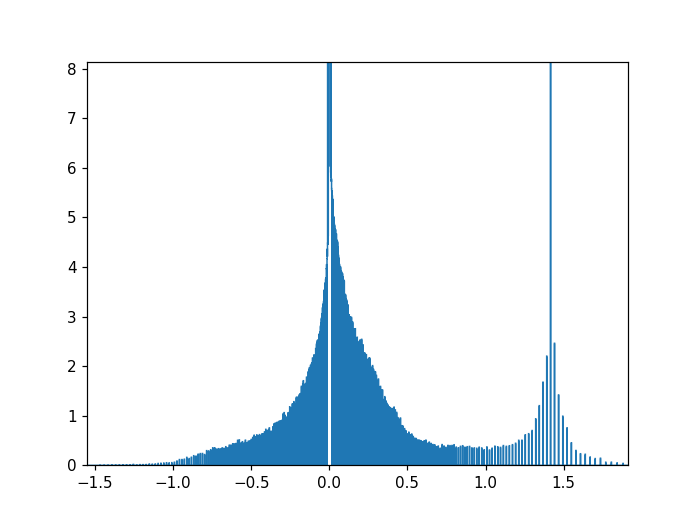

(720, 1280)


<IPython.core.display.Javascript object>


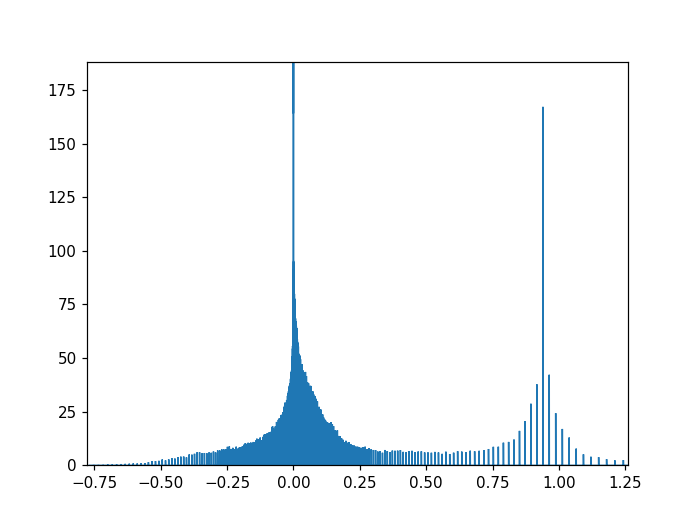

(720, 1280)


In [37]:
%matplotlib notebook
%matplotlib notebook



for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)

    plt.figure()
    plt.clf()
    Yplot = Y_lnl.flatten()
    plt.hist(Yplot,bins='auto',histtype='step',density=True)
    plt.show()

    print(Y_lnl.shape)

## Distorted MSCN images

<IPython.core.display.Javascript object>


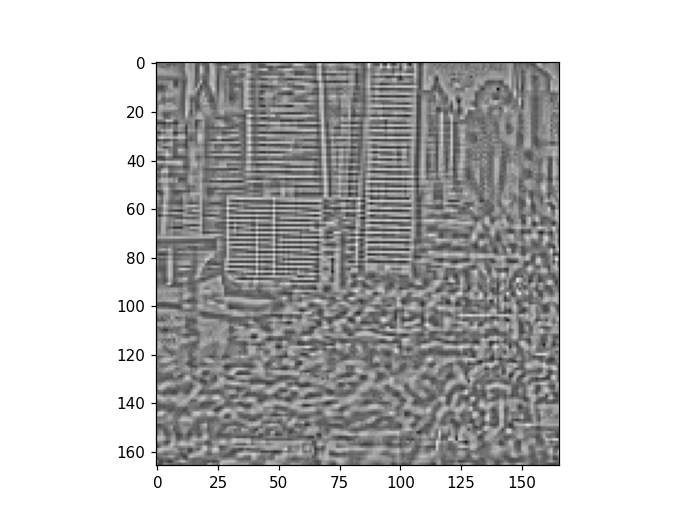

<IPython.core.display.Javascript object>


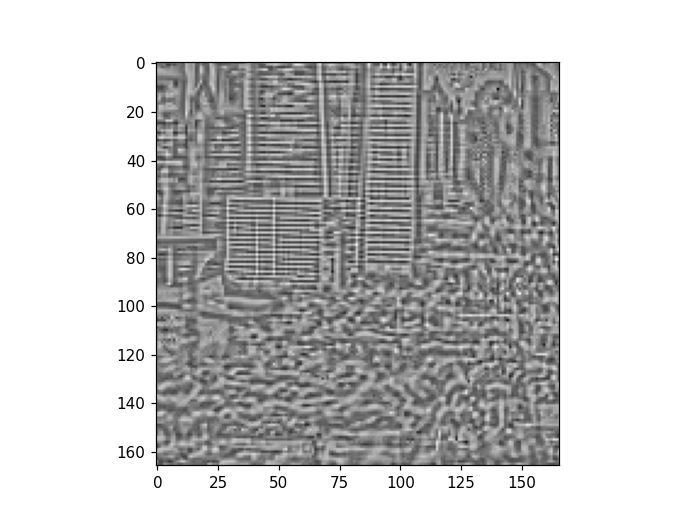

<IPython.core.display.Javascript object>


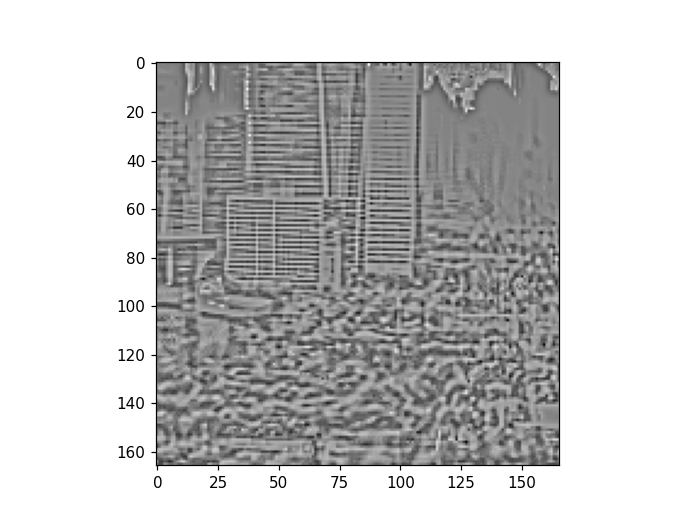

<IPython.core.display.Javascript object>


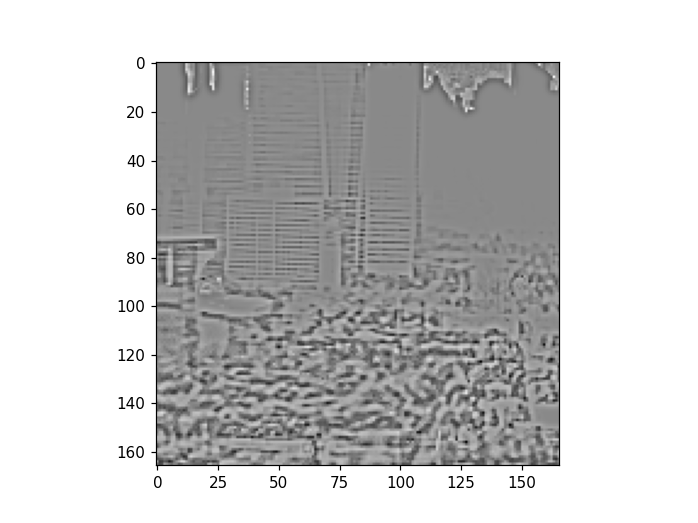

In [233]:
%matplotlib notebook
%matplotlib notebook

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)

%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = (Y_mscn-np.amin(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn[h_top:h_top+166,w_top:w_top+166],cmap='gray')
for Y_lnl_mscn in Y_lnl_mscn_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl_mscn-np.amin(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+166,w_top:w_top+166],cmap='gray')

<IPython.core.display.Javascript object>


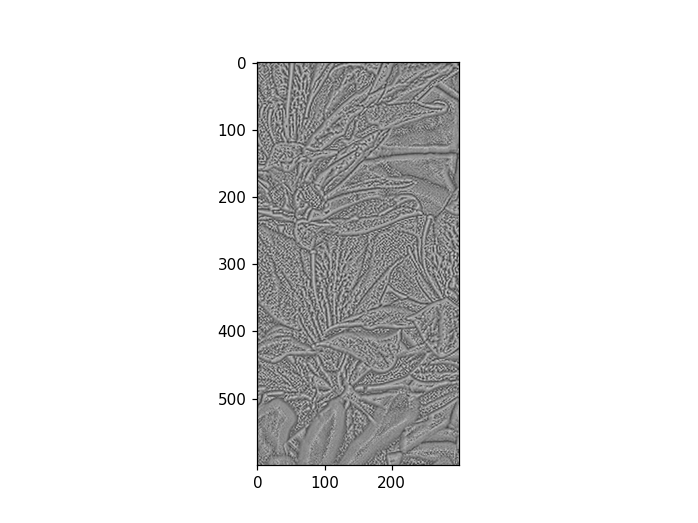

In [94]:
from matplotlib.colors import Normalize
plt.figure()
plt.clf()
Y_mscn_fcfs = (Y_mscn-np.min(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn_fcfs[1400:2000,1000:1300],norm=Normalize(),cmap='gray')

<IPython.core.display.Javascript object>


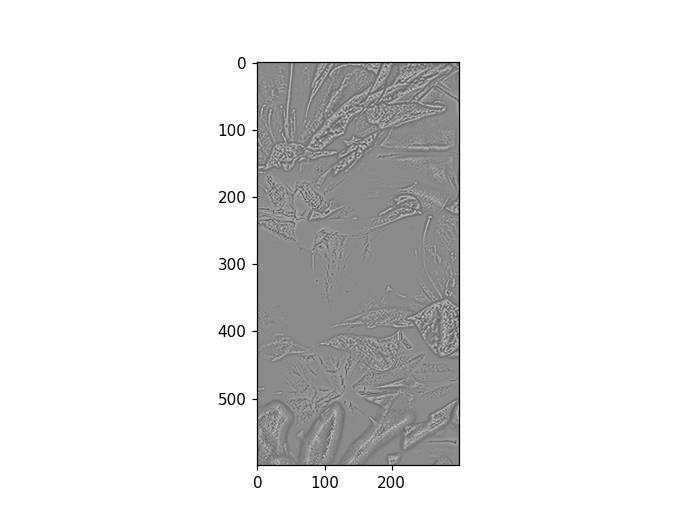

In [95]:
plt.figure()
plt.clf()
Y_lnl_mscn = Y_lnl_mscn_list[2]

plt.clf()
Y_fcfs = (Y_lnl_mscn-np.min(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))

plt.imshow(Y_fcfs[1400:2000,1000:1300],norm=Normalize(),cmap='gray')

In [ ]:
x = np.arange(0,1024)
y = x/(x+512)
plt.figure()
plt.clf()
plt.xlabel('L')
plt.ylabel('R')
plt.plot(x,y)

<IPython.core.display.Javascript object>


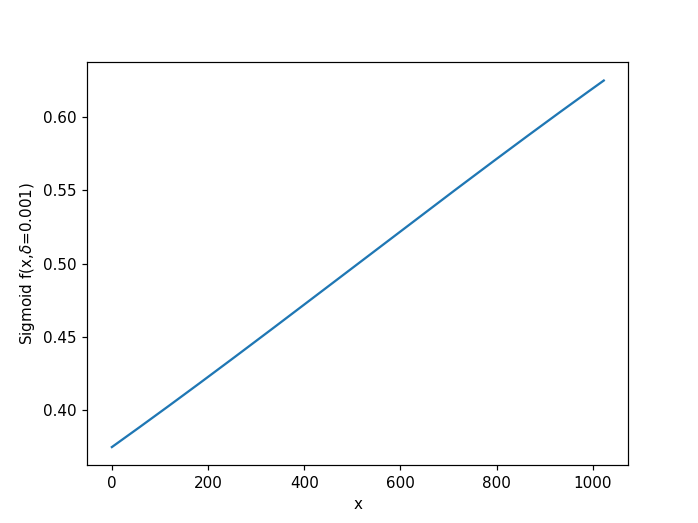

<IPython.core.display.Javascript object>


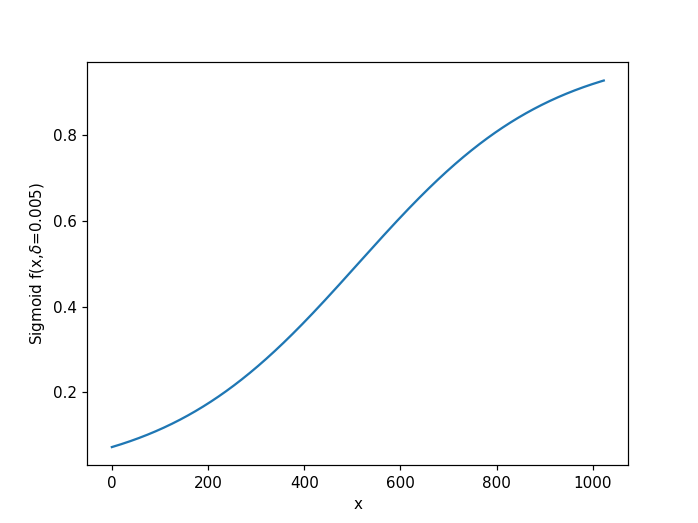

<IPython.core.display.Javascript object>


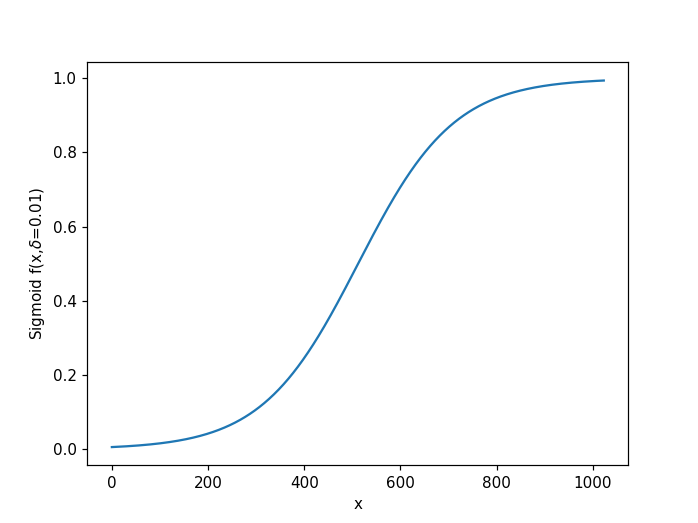

In [8]:
for delta in [0.001,0.005,0.01]:
    x = np.arange(0,1024)
    y = 1/(1+np.exp(-delta*(x-512)))
    plt.figure()
    plt.clf()
    plt.ylabel('Sigmoid f(x,$\delta$='+str(delta)+')')
    plt.xlabel('x')
    plt.plot(x,y)

<IPython.core.display.Javascript object>


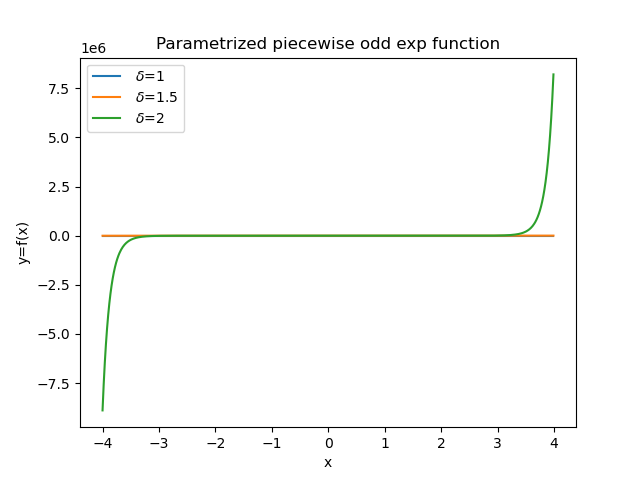

In [89]:
plt.figure()
plt.clf()
for delta in [1,1.5,2]:
    x = np.arange(-4,4,0.01)

    y2 = np.exp(np.abs(x)**delta)-1
    y2[x<0] = -y2[x<0]
#     print(y)


    plt.plot(x,y2,label=' $\delta$='+str(delta))
plt.legend()
plt.ylabel('y=f(x)')
plt.xlabel('x')
plt.title('Parametrized piecewise odd exp function')
plt.show()


/tmp/ipykernel_111923/2570013039.py:6: RuntimeWarning: divide by zero encountered in log
  y = np.log((1+x_d)/(1-x_d))
/tmp/ipykernel_111923/2570013039.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = np.log((1+x_d)/(1-x_d))
/tmp/ipykernel_111923/2570013039.py:6: RuntimeWarning: divide by zero encountered in log
  y = np.log((1+x_d)/(1-x_d))


Text(0.5, 1.0, 'Parametrized logit function')

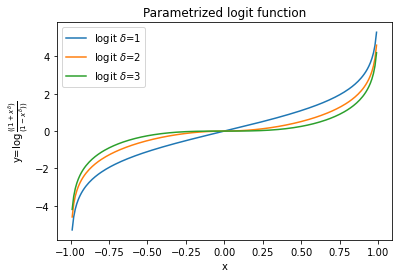

In [2]:
plt.figure()
plt.clf()
for delta in [1,2,3]:
    x = np.arange(-1,1,0.01)
    x_d = (x)**delta
    y = np.log((1+x_d)/(1-x_d))
    if(delta==2):
        y[x<0] = -y[x<0]
#     y2 = np.exp(x**delta)-1
#     y2[x<0] = -y2[x<0]
#     print(y)


    plt.plot(x,y,label='logit $\delta$='+str(delta))
#     plt.plot(x,y2,label='exp $\delta$='+str(delta))
plt.legend()
plt.ylabel('y=$\log \\frac{((1+x^{\delta})}{(1-x^{\delta}))}$')
plt.xlabel('x')
plt.title('Parametrized logit function')

<IPython.core.display.Javascript object>


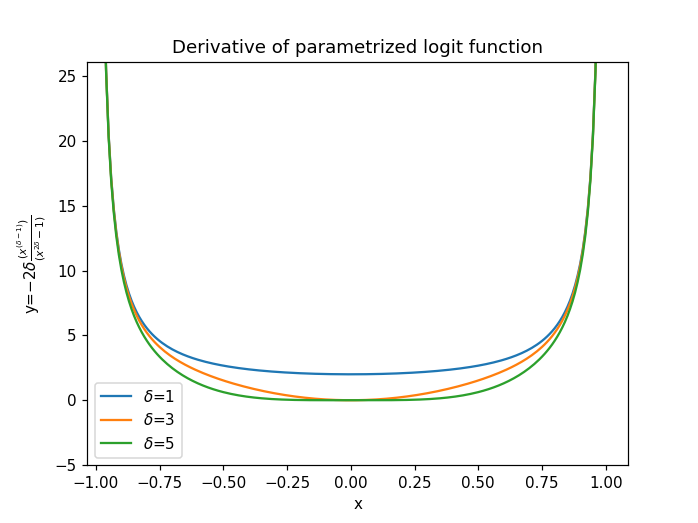

/tmp/ipykernel_204979/2701842226.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
/tmp/ipykernel_204979/2701842226.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
/tmp/ipykernel_204979/2701842226.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)


Text(0.5, 1.0, 'Derivative of parametrized logit function')

In [220]:
plt.figure()
plt.clf()
for delta in [1,3,5]:
    x = np.arange(-1,1,0.01)
    x_d = (x)**delta
    y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
#     print(y)


    plt.plot(x,y,label='$\delta$='+str(delta))
plt.legend()
plt.ylabel('y=$-2\delta \\frac{(x^{(\delta-1)})}{(x^{2\delta}-1)}$')
plt.xlabel('x')
plt.title('Derivative of parametrized logit function')

<IPython.core.display.Javascript object>


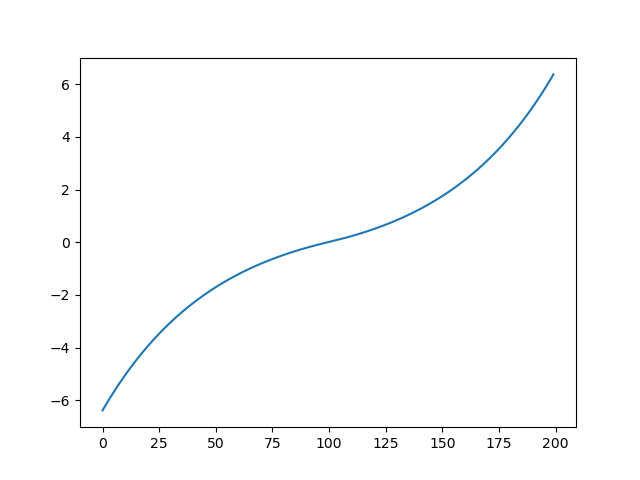

In [14]:
plt.figure()
block = np.arange(-1,1,0.01)
delta = 1
block = -2+(block-np.amin(block))* 4/(1e-3+np.amax(block)-np.amin(block))
block_transform =  np.exp(np.abs(block)**delta)-1
block_transform[block<0] = -block_transform[block<0]
plt.plot(block_transform)
plt.show()

<IPython.core.display.Javascript object>


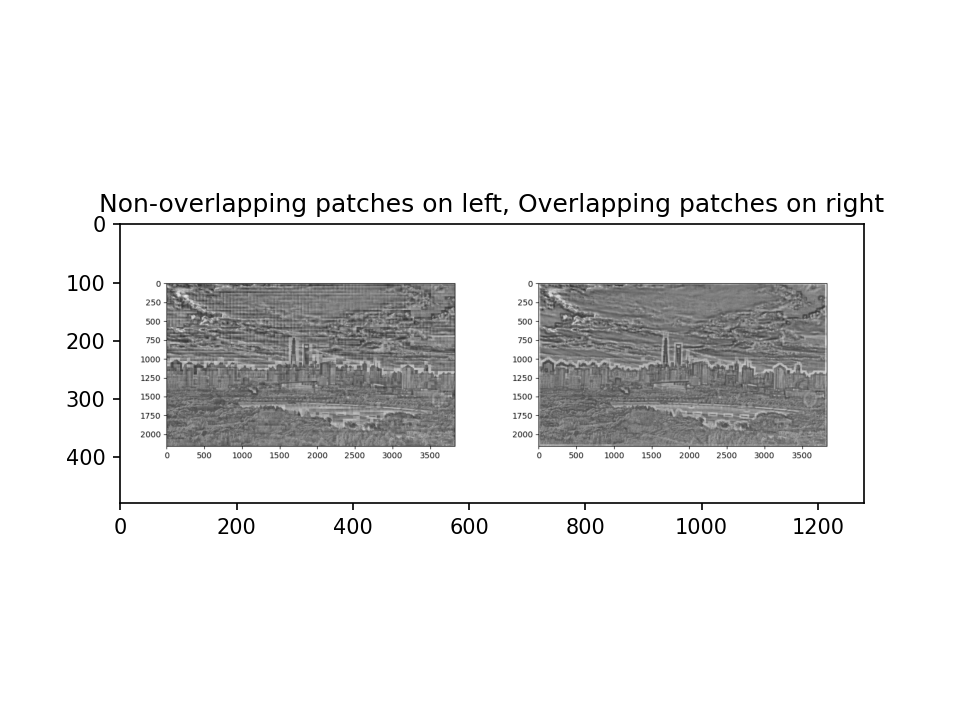

<IPython.core.display.Javascript object>


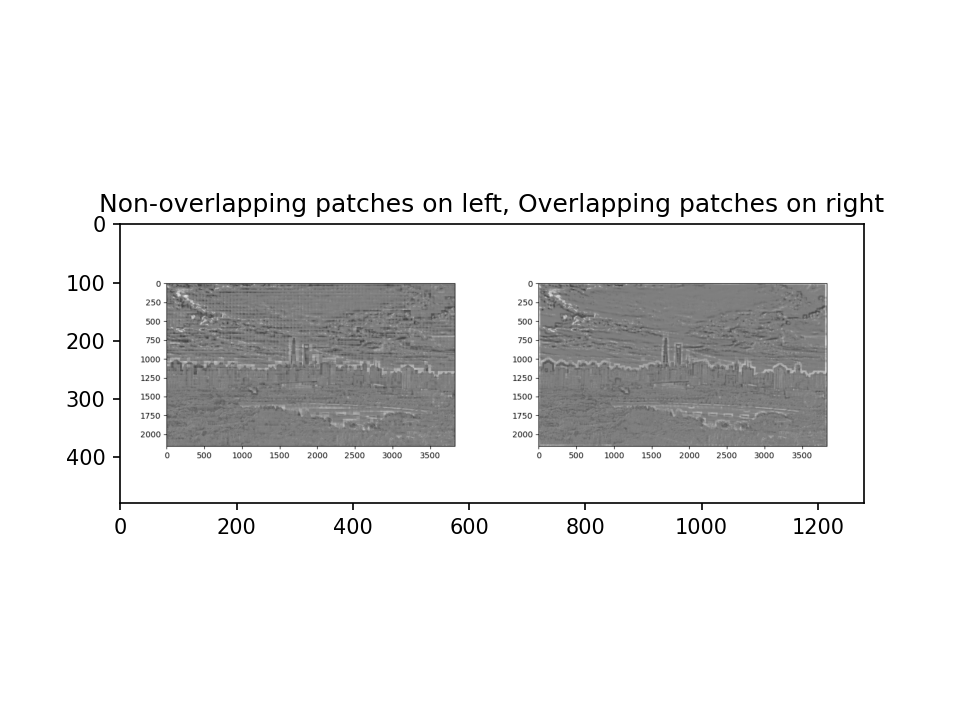

<IPython.core.display.Javascript object>


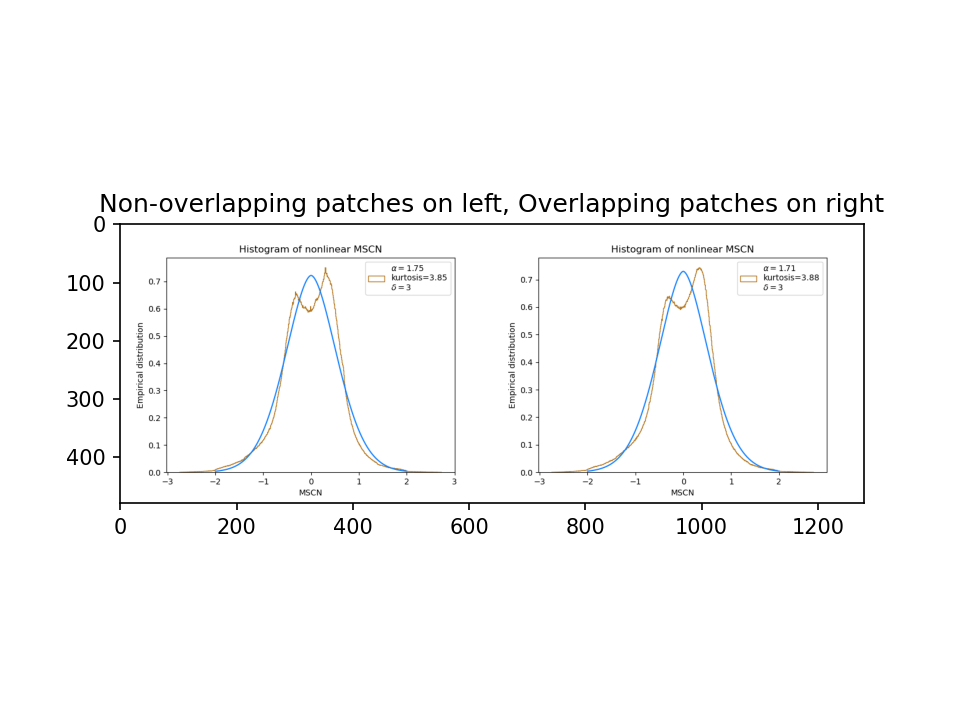

Text(0.5, 1.0, 'Non-overlapping patches on left, Overlapping patches on right')

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

img1 = cv2.imread('/home/josh-admin/Documents/hdr_plots/local_nonlinear_plots_v3/vid188_local_logit_delta1.png')
img2 = cv2.imread('/home/josh-admin/Documents/hdr_plots/sliding_window_lnl/vid188_logit_delta1.png')
im_v = cv2.hconcat([img1, img2])
plt.figure()
plt.imshow(im_v)
plt.title('Non-overlapping patches on left, Overlapping patches on right')

img1 = cv2.imread('/home/josh-admin/Documents/hdr_plots/local_nonlinear_plots_v3/vid188_local_logit_delta3.png')
img2 = cv2.imread('/home/josh-admin/Documents/hdr_plots/sliding_window_lnl/vid188_logit_delta3.png')
im_v = cv2.hconcat([img1, img2])
plt.figure()
plt.imshow(im_v)
plt.title('Non-overlapping patches on left, Overlapping patches on right')


img1 = cv2.imread('/home/josh-admin/Documents/hdr_plots/local_nonlinear_plots_v3/vid188_local_logit_delta3_mscn_hist.png')
img2 = cv2.imread('/home/josh-admin/Documents/hdr_plots/sliding_window_lnl/vid188_logit_delta3_mscn_hist.png')
im_v = cv2.hconcat([img1, img2])
plt.figure()
plt.imshow(im_v)
plt.title('Non-overlapping patches on left, Overlapping patches on right')


In [40]:
np.exp(8)

2980.9579870417283